## Test 1.1: take 3 images with random PWM values

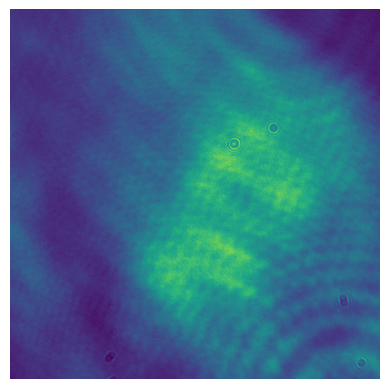

In [1]:
import csv
import numpy as np
import random
import time
from PIL import Image
from imageio import imwrite,imread
import os
from pylablib.devices import Thorlabs
from PIL import Image
import PIL.ImageOps 
import matplotlib.pyplot as plt 
def mkdir(path):
	folder = os.path.exists(path)
	if not folder:                   
		os.makedirs(path)    

from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
# cam.close()
cam.set_exposure(0.0001) # set exposure to 100ms
# frame = cam.snap() # grab a single frame
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner
#images = cam.grab(10) # grab 10 frames

i=0
while i<= 2:
#     A = np.array([[0],[0],[1000],[0],[3000]], dtype=np.int32)
    A = np.random.randint(low=0,high=4000,size=(5,1), dtype=np.int32)   # range form 0 to 3000
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    time.sleep(0.1) 
    fig_name = 'pwm='+str(int(A[0]))+'-'+str(int(A[1]))+'-'+str(int(A[2]))+'-'+str(int(A[3]))+'-'+str(int(A[4])) +'-'+str(int(i))
    raw_image_array = cam.grab(1)    # grab 1 frame
    image_array=np.array(raw_image_array)
    squeezed_image_array=image_array.squeeze()
    # image = plt.imshow(squeezed_image_array)
    
    # Display the image without axes
    plt.axis('off')
    plt.imshow(squeezed_image_array)  # Set the desired colormap if needed

    # Save the image without axes
#     plt.savefig('image_without_axes.png', bbox_inches='tight', pad_inches=0)
    plt.savefig(r'C:\Users\plasma\Desktop\jakob_imgs\{fig_name}.png'.format(fig_name=fig_name))  # Save the plot
    
    import pickle # see for usage: https://www.digitalocean.com/community/tutorials/python-pickle-example
    file = open(r'C:\Users\plasma\Desktop\jakob_imgs\{fig_name}.pkl'.format(fig_name=fig_name), "wb")
    pickle.dump(squeezed_image_array, file)
    file.close()
    i=i+1
#can use this to add aberration or add it on pi,see pi_control.py file
cam.close()

## Benchmark Loop

1. Compare Random to BO
2. Save results for evaluation

pip --no-cache-dir install botorch --user


In [2]:
def set_PWMs(pwms):
    # Your code that sets the PWMs
    A = np.array([[pwms[0]], [pwms[1]], [pwms[2]], [pwms[3]], [pwms[4]]])
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    return 0

In [3]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
# cam.close()
cam.set_exposure(0.0001) # set exposure to 100ms
# frame = cam.snap() # grab a single frame
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)

In [4]:
def get_quality():

    #take image and calculate the quality number
    raw_image_array = cam.grab(10)    # grab 10 frame
    image_array=np.array(raw_image_array)
    squeezed_image_array=image_array.squeeze()
    score=[]
    for i in range (len(squeezed_image_array)):
        x=np.linspace(0,1000,1000)
        [m,n]=np.where(squeezed_image_array[i]==np.max(squeezed_image_array[i]))
        mode_info_m = stats.mode(m, keepdims=True)  ##col
        mode_info_n = stats.mode(n, keepdims=True) ##row
        a=int(mode_info_m[0])
        b=int(mode_info_n[0])
        c=5 #box half-thickness
        y_x=0

        for j in range (a-c,a+c):
            y_x=y_x+squeezed_image_array[i][j,:]/100 #tricky here since if this number is >255 it becomes 0.
        y_x=(y_x)/c*100

        y_y=0

        for j in range (b-c,b+c):
            y_y=y_y+squeezed_image_array[i][:,j]/100
        y_y=((y_y)/c)*100

        popt_x, pcov_x = optimize.curve_fit(gaussian, x, y_x+1,maxfev=500000) # tricky here!!!!! y_x+1
        fitted_y_x=popt_x[0] * np.exp(-((x - popt_x[1]) / 4 / popt_x[2])**2)
        a_x=r2_score(y_x,fitted_y_x)
        popt_y, pcov_y = optimize.curve_fit(gaussian, x, y_y+1,maxfev=500000) # same here!!!! y_y+1
        fitted_y_y=popt_y[0] * np.exp(-((x - popt_y[1]) / 4 / popt_y[2])**2)
        a_y=r2_score(y_y,fitted_y_y)

        s=abs(a_x*a_y)
        score.append(s)
        average_score=np.mean(score)
        quality_number = average_score
        time.sleep(0.1) # wait for 0.1 second and then reset the mirror by annealing
        # Annealing
        with open('PWM_test.csv', 'r', encoding='utf-8') as pwm_file:
            pwm_data = pwm_file.readlines()
        # Write data to do_annealing.csv
        with open('do_annealing.csv', 'w', encoding='utf-8') as annealing_file:
            annealing_file.writelines(pwm_data)
        time.sleep(0.5)
    return quality_number

In [5]:
# SYNTHESIS and CHARACTERISATION
from OptimizationTestFunctions import Sphere, plot_3d
def set_PWMs_and_get_quality(pwms,sphere_test=False):
    if sphere_test:
        f = Sphere(dim=5,degree=2)
        #return -1*f(pwms)
        return -1*f(pwms)/1000000
    else:
        # Zoe fills in above:
        set_PWMs(pwms)
        quality_number = get_quality()
        return quality_number

In [6]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

In [7]:
# Random Strategy

import random
def get_random_PWMs():
    #return [random.uniform(0,5) for i in range(5)]
    return [random.uniform(0,4095) for i in range(5)]
get_random_PWMs()

[1598.7462298669882,
 1423.0517273938071,
 2225.6663604116266,
 1452.5744829416267,
 1250.4948775122082]

In [8]:
# Bayesian Opt Strategy

import numpy as np
import pandas as pd

from botorch.acquisition import qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler

sampler = SobolQMCNormalSampler(sample_shape=torch.Size([512]), seed=0)
torch.manual_seed(seed=0)  # to keep the restart conditions the same    

def calculate_BO_candidate(samples):
    train_X = samples[["p1","p2","p3","p4","p5"]]
    train_Y = samples[["error"]]

    train_X = torch.tensor(train_X.to_numpy(dtype=np.float64))
    train_Y = torch.tensor(train_Y.to_numpy(dtype=np.float64))

    gp = SingleTaskGP(train_X, train_Y, input_transform=Normalize(d=train_X.shape[-1]), outcome_transform=Standardize(m=train_Y.shape[-1]),)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    #from botorch.acquisition import UpperConfidenceBound
    #UCB = UpperConfidenceBound(gp, beta=.1)

    MC_EI = qExpectedImprovement(gp, best_f=train_Y.max(), sampler=sampler)
    
    
    from botorch.optim import optimize_acqf
    bounds = torch.stack([torch.zeros(5), torch.ones(5)*4095])
    #bounds = torch.stack([torch.zeros(5), torch.ones(5)*5])

    candidate, acq_value = optimize_acqf(
        MC_EI, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    candidate = candidate[0]
    return candidate

Optimisation Loop:

In [9]:
N_TRIALS = 15
N_ITERATIONS = 40
USE_TEST_FUNCTION = False

best_random_all = []
best_BO_all = []
random_trial_samples =[]
BO_trial_samples =[]
import time
for trial in range(N_TRIALS):
    print(f"Trail {trial}")
    BO_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial',"iteration", "timestamp"])
    random_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial', "iteration", "timestamp"])
    BO_current_candidate = get_random_PWMs() # We will start the BO with a random PWMs as well
    random_current_candidate = get_random_PWMs()
    
    best_random =[]
    best_BO =[]

    for iteration in range(N_ITERATIONS):
        #print(f"Trail {trial}, Iteration {iteration}")
        
        # RANDOM
        # STEP 1 and 2 Synthesis and Characterisation
        random_current_quality = set_PWMs_and_get_quality(random_current_candidate, sphere_test=USE_TEST_FUNCTION)   
        new_sample = {f"p{i+1}":p for i, p in enumerate(random_current_candidate)}
        new_sample["error"] = random_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] =  trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        random_samples = pd.concat([random_samples, new_sample], axis=0, ignore_index=True)    
        # STEP 3 Planning
        random_current_candidate = get_random_PWMs()
        
        # BO
        # STEP 1 and 2 Synthesis and Characterisation
        BO_current_quality = set_PWMs_and_get_quality(BO_current_candidate, sphere_test=USE_TEST_FUNCTION)    
        new_sample = {f"p{i+1}":p for i, p in enumerate(BO_current_candidate)}
        new_sample["error"] = BO_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] =  trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        BO_samples = pd.concat([BO_samples, new_sample], axis=0, ignore_index=True)    
        # STEP 3 Planning
        if iteration < 10:
            BO_current_candidate = get_random_PWMs() # We will have 10 random initial points to start with
        else:
            BO_current_candidate = calculate_BO_candidate(BO_samples)
        
        
        # Update Progress
        best_random.append(random_samples["error"].max())
        best_BO.append(BO_samples["error"].max())
        
    random_trial_samples.append(random_samples.copy(deep=True))
    BO_trial_samples.append(BO_samples.copy(deep=True))
    
    best_random_all.append(best_random)
    best_BO_all.append(best_BO)
        

Trail 0
Trail 1
Trail 2
Trail 3


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Trail 4


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Trail 5
Trail 6
Trail 7
Trail 8


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Trail 9


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Trail 10


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Trail 11


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Trail 12


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Trail 13
Trail 14


In [10]:
BO_trial_samples[3]

,p1,p2,p3,p4,p5,error,trial,iteration,timestamp
0,1429.71061,2252.660154,2005.302865,311.637415,1278.609353,0.248383,3,0,1.691706e+09
1,3679.794708,146.89669,430.448759,752.777647,1885.853922,0.267805,3,1,1.691706e+09
2,2970.445493,3189.326711,602.301103,3785.077577,823.531301,0.365731,3,2,1.691706e+09
3,1163.610242,38.542125,1072.592702,1548.132234,1184.129838,0.259995,3,3,1.691706e+09
4,833.001967,3564.209371,127.564584,2969.197702,3763.880602,0.189771,3,4,1.691706e+09
5,1854.308403,3605.058931,2903.687297,2735.661573,1216.09953,0.272079,3,5,1.691706e+09
6,76.68274,1048.992575,2824.388657,2337.992671,3073.057554,0.190957,3,6,1.691706e+09
7,1156.854999,1428.472827,1020.022749,102.352794,1451.279909,0.346415,3,7,1.691706e+09
8,377.224441,2731.086021,3339.296485,2817.880876,1257.148143,0.245904,3,8,1.691706e+09
9,233.349213,2160.32955,3105.597511,2460.011174,2209.988835,0.213683,3,9,1.691706e+09


In [11]:
best_BO_all

[[0.31158445491631,
  0.36647061360023653,
  0.3968387502317168,
  0.3968387502317168,
  0.3968387502317168,
  0.3968387502317168,
  0.3968387502317168,
  0.3968387502317168,
  0.3968387502317168,
  0.3968387502317168,
  0.3968387502317168,
  0.3968387502317168,
  0.3968387502317168,
  0.3968387502317168,
  0.3968387502317168,
  0.3968387502317168,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429,
  0.445846735462429],
 [0.3820996484703773,
  0.39005841849169015,
  0.39005841849169015,
  0.39005841849169015,
  0.39005841849169015,
  0.39005841849169015,
  0.390

## Plot results

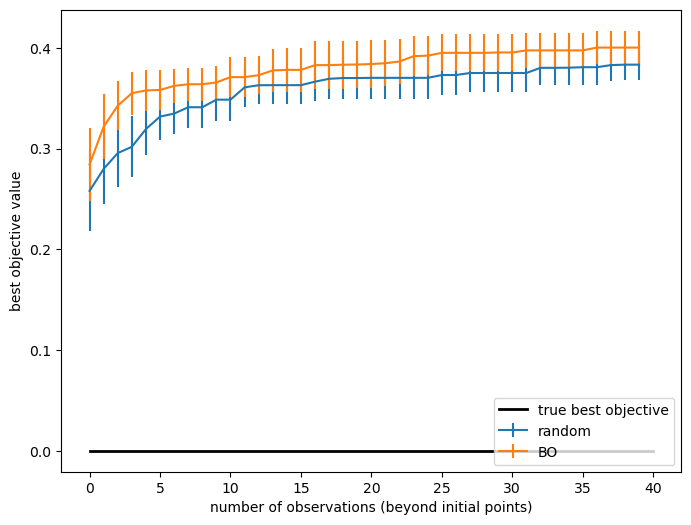

In [19]:
import numpy as np
from matplotlib import pyplot as plt


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


GLOBAL_MAXIMUM = 0 # Sphere is optimised at 0


iters = np.arange(N_ITERATIONS)
y_random = np.asarray(best_random_all)
y_BO = np.asarray(best_BO_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_random.mean(axis=0), yerr=ci(y_random), label="random", linewidth=1.5)
ax.errorbar(iters, y_BO.mean(axis=0), yerr=ci(y_BO), label="BO", linewidth=1.5)
plt.plot(
    [0, N_ITERATIONS],
    [GLOBAL_MAXIMUM] * 2,
    "k",
    label="true best objective",
    linewidth=2,
)
#ax.set_ylim(bottom=0.5)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="best objective value",
)
ax.legend(loc="lower right")

In [13]:
y_BO

array([[0.31158445, 0.36647061, 0.39683875, 0.39683875, 0.39683875,
        0.39683875, 0.39683875, 0.39683875, 0.39683875, 0.39683875,
        0.39683875, 0.39683875, 0.39683875, 0.39683875, 0.39683875,
        0.39683875, 0.44584674, 0.44584674, 0.44584674, 0.44584674,
        0.44584674, 0.44584674, 0.44584674, 0.44584674, 0.44584674,
        0.44584674, 0.44584674, 0.44584674, 0.44584674, 0.44584674,
        0.44584674, 0.44584674, 0.44584674, 0.44584674, 0.44584674,
        0.44584674, 0.44584674, 0.44584674, 0.44584674, 0.44584674],
       [0.38209965, 0.39005842, 0.39005842, 0.39005842, 0.39005842,
        0.39005842, 0.39005842, 0.39005842, 0.39005842, 0.39005842,
        0.39005842, 0.39005842, 0.39005842, 0.39005842, 0.39005842,
        0.39005842, 0.39005842, 0.39005842, 0.39661854, 0.39661854,
        0.39661854, 0.39661854, 0.39661854, 0.39661854, 0.39661854,
        0.39661854, 0.39661854, 0.39661854, 0.39661854, 0.39661854,
        0.39661854, 0.39661854, 0.39661854, 0.3

In [14]:
y_random

array([[0.38026649, 0.38026649, 0.39789176, 0.39789176, 0.40411434,
        0.40411434, 0.40411434, 0.40411434, 0.40411434, 0.40411434,
        0.40411434, 0.40411434, 0.40411434, 0.40411434, 0.40411434,
        0.40411434, 0.42780629, 0.43368174, 0.43368174, 0.43368174,
        0.43368174, 0.43368174, 0.43368174, 0.43368174, 0.43368174,
        0.43368174, 0.43368174, 0.43368174, 0.43368174, 0.43368174,
        0.43368174, 0.43368174, 0.43368174, 0.43368174, 0.43368174,
        0.43368174, 0.43368174, 0.43368174, 0.43368174, 0.43368174],
       [0.36623604, 0.36623604, 0.36623604, 0.36623604, 0.36623604,
        0.36623604, 0.36623604, 0.38486886, 0.38486886, 0.38486886,
        0.38486886, 0.38486886, 0.38486886, 0.38486886, 0.38486886,
        0.38486886, 0.38486886, 0.40061052, 0.41188287, 0.41188287,
        0.41188287, 0.41188287, 0.41188287, 0.41188287, 0.41188287,
        0.41188287, 0.41188287, 0.41188287, 0.41188287, 0.41188287,
        0.41188287, 0.41188287, 0.41188287, 0.4

In [15]:
cam.close()